Dataset Link : https://www.kaggle.com/datasets/riazulhasanprince/tea-sickness-dataset

In [3]:
!pip install kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d riazulhasanprince/tea-sickness-dataset

Dataset URL: https://www.kaggle.com/datasets/riazulhasanprince/tea-sickness-dataset
License(s): unknown
100% 740M/740M [00:41<00:00, 20.6MB/s]
100% 740M/740M [00:41<00:00, 18.8MB/s]


In [9]:
import zipfile
zip_ref = zipfile.ZipFile('/content/tea-sickness-dataset.zip', 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [10]:
!pip install torch torchvision pylance pyresearch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.4/25.4 MB 4.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [11]:
# 1. Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image

In [17]:
import numpy as np
import os
import pathlib
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from scipy.signal import welch

In [18]:
dataset_path = "/content/dataset/tea leaf dataset/train"
dataset_dir = pathlib.Path(dataset_path)

In [20]:
# Setting parameters for feature extraction
train_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)

In [21]:
# Load images and labels
X = []
y = []
for class_i, class_name in enumerate(os.listdir(dataset_path)):
    class_dir = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_dir):
        if not img_name.startswith('.'):  # Exclude system files
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)
            img = img.resize((img_height, img_width))
            img_array = np.array(img)
            X.append(img_array)
            y.append(class_i)

X = np.array(X)
y = np.array(y)

In [22]:
X_reshaped = X.reshape((X.shape[0], -1))

from scipy.signal import welch

# Compute PSD features for each image
psd_features = []
for img in X:
    img_flat = img.flatten()  # Flatten the image
    _, psd = welch(img_flat)  # Compute PSD
    psd_features.append(psd)

psd_features = np.array(psd_features)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Flatten each image array and convert to string
X_as_strings = [' '.join(map(str, img.flatten())) for img in X_reshaped]

# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(X_as_strings)


# Feature extraction using PCA (Principal Component Analysis)
pca = PCA(n_components=100)
pca_features = pca.fit_transform(X_reshaped)

In [24]:
# Feature extraction using PCA (Principal Component Analysis)
pca = PCA(n_components=100)
pca_features = pca.fit_transform(X_reshaped)

# Concatenate all features
combined_features = np.concatenate((X_reshaped, psd_features, tfidf_features.toarray(), pca_features), axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.2, random_state=42)

In [25]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers (SVM and Random Forest)
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_scaled, y_train)

rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [26]:
# Combine classifiers for voting
voting_classifier = VotingClassifier(estimators=[
    ('svm', svm_classifier),
    ('rf', rf_classifier)
], voting='hard')

voting_classifier.fit(X_train_scaled, y_train)

# Combine classifiers for bagging
bagging_classifier = BaggingClassifier(base_estimator=svm_classifier, n_estimators=10, random_state=42)
bagging_classifier.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=SVC(kernel='linear', random_state=42),
                  random_state=42)

In [36]:
train_features = []
train_labels = []
for images, labels in train_ds:
    features = model(images)
    train_features.extend(features.numpy())
    train_labels.extend(labels.numpy())

In [37]:
# Extract features for validation data
val_features = []
val_labels = []
for images, labels in val_ds:
    features = model(images)
    val_features.extend(features.numpy())
    val_labels.extend(labels.numpy())

In [38]:
train_features = np.array(train_features)
train_labels = np.array(train_labels)
val_features = np.array(val_features)
val_labels = np.array(val_labels)

In [39]:
svm_classifier = make_pipeline(StandardScaler(), SVC())
svm_classifier.fit(train_features, train_labels)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [40]:
val_predictions = svm_classifier.predict(val_features)
print(classification_report(val_labels, val_predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           6       0.96      0.96      0.96        28
           7       0.99      0.92      0.95       113

    accuracy                           0.93       141
   macro avg       0.49      0.47      0.48       141
weighted avg       0.99      0.93      0.96       141



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
from sklearn.metrics import accuracy_score

# Calculate overall accuracy
overall_accuracy = accuracy_score(val_labels, val_predictions)
print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.9290780141843972


In [42]:
# Evaluate SVM classifier
val_predictions = svm_classifier.predict(val_features)
print(classification_report(val_labels, val_predictions))

# Calculate overall accuracy
overall_accuracy = accuracy_score(val_labels, val_predictions)
print("Overall Accuracy:", overall_accuracy)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           6       0.96      0.96      0.96        28
           7       0.99      0.92      0.95       113

    accuracy                           0.93       141
   macro avg       0.49      0.47      0.48       141
weighted avg       0.99      0.93      0.96       141

Overall Accuracy: 0.9290780141843972


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

In [45]:
# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features, train_labels)

RandomForestClassifier(random_state=42)

In [46]:
ensemble_classifier = VotingClassifier(estimators=[
    ('svm', svm_classifier),
    ('random_forest', rf_classifier)],
    voting='hard')

In [47]:
# Train the ensemble classifier
ensemble_classifier.fit(train_features, train_labels)

VotingClassifier(estimators=[('svm',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc', SVC())])),
                             ('random_forest',
                              RandomForestClassifier(random_state=42))])

In [48]:
val_predictions_ensemble = ensemble_classifier.predict(val_features)
ensemble_accuracy = accuracy_score(val_labels, val_predictions_ensemble)
print("Ensemble Accuracy (SVM + Random Forest):", ensemble_accuracy)

Ensemble Accuracy (SVM + Random Forest): 0.9219858156028369


In [49]:
def predict_disease(test_img_path):
    test_image = tf.keras.preprocessing.image.load_img(test_img_path, target_size=(img_height, img_width))  # Load image
    test_image_array = tf.keras.preprocessing.image.img_to_array(test_image)  # Convert image to numpy array
    test_image_array = tf.expand_dims(test_image_array, axis=0)  # Add batch dimension

    # Extract features using the pre-trained model
    features = model.predict(test_image_array)

    # Predict using the ensemble classifier
    disease_prediction = ensemble_classifier.predict(features)

    # Define class labels
    class_names = ['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']

    # Display the predicted disease
    predicted_disease = class_names[disease_prediction[0]]
    print("Predicted Disease:", predicted_disease)

    # Display the image
    plt.imshow(test_image)
    plt.title("Predicted Disease: " + predicted_disease)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 99ms/step
Predicted Disease: healthy


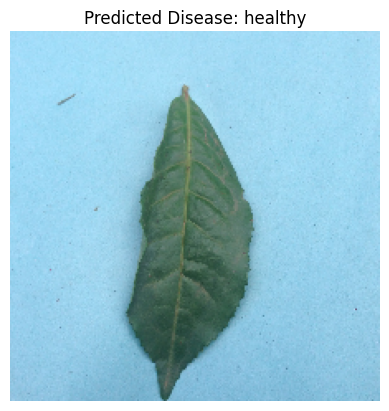

In [50]:
test_image = '/content/dataset/tea leaf dataset/valid/healthy/UNADJUSTEDNONRAW_thumb_23a.jpg'
predict_disease(test_image)

1/1 [==============================] - 0s 95ms/step
Predicted Disease: Anthracnose


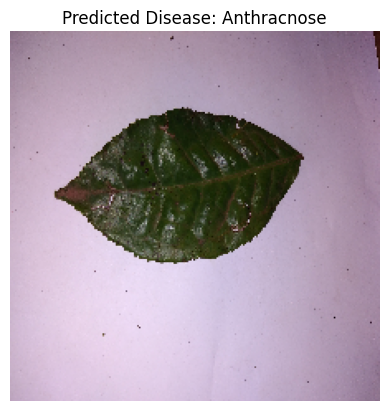

In [51]:
test_image = '/content/dataset/tea leaf dataset/valid/bird eye spot/IMG_20220503_154332.jpg'
predict_disease(test_image)

1/1 [==============================] - 0s 104ms/step
Predicted Disease: gray light


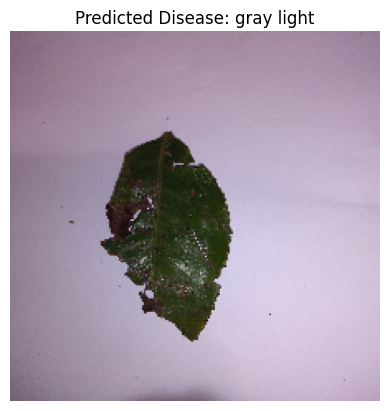

In [52]:
test_image = '/content/dataset/tea leaf dataset/valid/gray light/IMG_20220503_135418.jpg'
predict_disease(test_image)

1/1 [==============================] - 0s 118ms/step
Predicted Disease: algal leaf


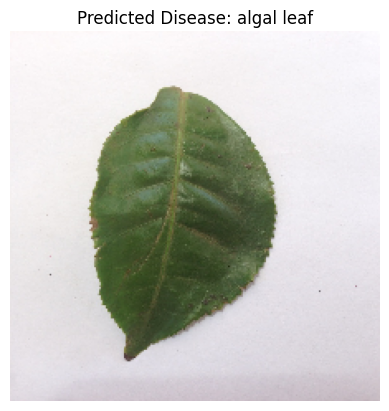

In [53]:
test_image = '/content/dataset/tea leaf dataset/valid/algal leaf/UNADJUSTEDNONRAW_thumb_3.jpg'
predict_disease(test_image)

Stacking

In [9]:
import numpy as np
import os
import PIL
from scipy.signal import welch

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [10]:
# Dataset path
dataset_path = "/content/dataset/tea leaf dataset/train"
dataset_dir = pathlib.Path(dataset_path)

In [11]:
# Get class names
class_names = [x for x in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, x))]

# Parameter setting
train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.2

In [12]:
#Load data for Training
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=val_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=train_batch,
    shuffle=True
)

# Load data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=val_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=val_batch,
    shuffle=False
)

Found 708 files belonging to 8 classes.
Using 567 files for training.
Found 708 files belonging to 8 classes.
Using 141 files for validation.


In [13]:
# Extract features using the pre-trained model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [14]:
# Add a global average pooling layer to extract features
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
model = tf.keras.Model(inputs, x)

In [15]:
# Function to compute PSD for an image
def compute_psd(image):
    # Convert image to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    # Convert image to numpy array
    image_array = np.array(grayscale_image)
    # Compute PSD using Welch's method
    f, Pxx = welch(image_array, axis=0)
    return Pxx

# Extract features and PSD for training data
train_features = []
train_labels = []
train_psd_features = []

for images, labels in train_ds:
    features = model(images)
    psd_features = [compute_psd(image) for image in images]
    train_features.extend(features.numpy())
    train_psd_features.extend(psd_features)
    train_labels.extend(labels.numpy())

# Extract features and PSD for validation data
val_features = []
val_labels = []
val_psd_features = []

for images, labels in val_ds:
    features = model(images)
    psd_features = [compute_psd(image) for image in images]
    val_features.extend(features.numpy())
    val_psd_features.extend(psd_features)
    val_labels.extend(labels.numpy())

/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 224, using nperseg = 224
  warnings.warn('nperseg = {0:d} is greater than input length '


In [16]:
# Convert lists to arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)
train_psd_features = np.array(train_psd_features)

val_features = np.array(val_features)
val_labels = np.array(val_labels)
val_psd_features = np.array(val_psd_features)

In [17]:
svm_classifier = SVC(kernel='linear', random_state=42)

In [20]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Define the base estimators for stacking
# Create an instance of the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
estimators = [
    ('svm', svm_classifier),
    ('rf', rf_classifier)
]

In [21]:
# Initialize the meta-learner (logistic regression)
meta_learner = LogisticRegression()

# Create the stacking classifier
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=5  # Number of cross-validation folds
)

In [22]:
from sklearn.metrics import accuracy_score, classification_report
#Fit the stacking classifier to the training data
stacking_classifier.fit(train_features, train_labels)

# Make predictions using the stacking classifier
val_predictions_stacking = stacking_classifier.predict(val_features)

# Calculate accuracy and print classification report for the stacking classifier
accuracy_stacking = accuracy_score(val_labels, val_predictions_stacking)
print("Stacking Accuracy:", accuracy_stacking)
print("Classification Report (Stacking):\n", classification_report(val_labels, val_predictions_stacking))

Stacking Accuracy: 0.9787234042553191
Classification Report (Stacking):
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           6       1.00      0.96      0.98        28
           7       0.99      0.98      0.99       113

    accuracy                           0.98       141
   macro avg       0.50      0.49      0.49       141
weighted avg       0.99      0.98      0.99       141



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

In [23]:
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt

In [24]:
# Save the stacking classifier
joblib.dump(stacking_classifier, 'stacking_classifier_model.joblib')

# Load the stacking classifier
loaded_stacking_classifier = joblib.load('stacking_classifier_model.joblib')

In [25]:
def predict_disease(test_img_path):
    test_image = tf.keras.preprocessing.image.load_img(test_img_path, target_size=(img_height, img_width))  # Load image
    test_image_array = tf.keras.preprocessing.image.img_to_array(test_image)  # Convert image to numpy array

    # Extract features using the pre-trained model
    features = model.predict(tf.expand_dims(test_image_array, axis=0)).flatten()

    # Predict using the stacking classifier
    disease_prediction = stacking_classifier.predict(features.reshape(1, -1))

    # Define class labels
    class_names = ['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']

    # Display the predicted disease
    predicted_disease = class_names[disease_prediction[0]]
    print("Predicted Disease:", predicted_disease)

    # Display the image
    plt.imshow(test_image)
    plt.title("Predicted Disease: " + predicted_disease)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 3s 3s/step
Predicted Disease: Anthracnose


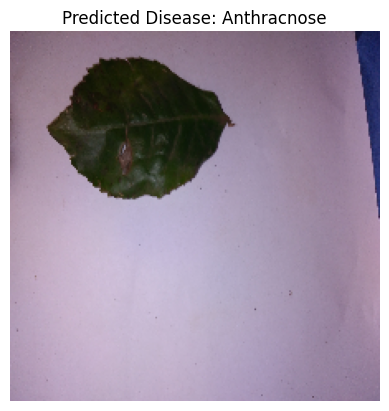

In [27]:
# Test image path
test_image = '/content/dataset/tea leaf dataset/train/Anthracnose/IMG_20220503_143740.jpg'

# Call the predict_disease_with_loaded_model function
predict_disease(test_image)

1/1 [==============================] - 0s 82ms/step
Predicted Disease: healthy


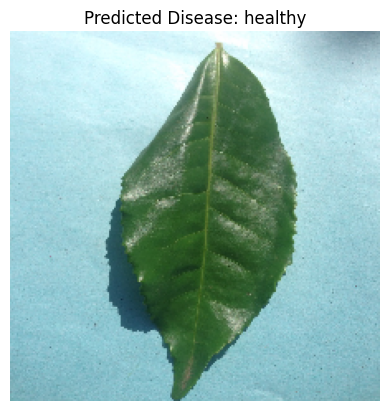

In [28]:
# Test image path
test_image = '/content/dataset/tea leaf dataset/train/healthy/UNADJUSTEDNONRAW_thumb_211.jpg'

# Call the predict_disease_with_loaded_model function
predict_disease(test_image)

1/1 [==============================] - 0s 90ms/step
Predicted Disease: gray light


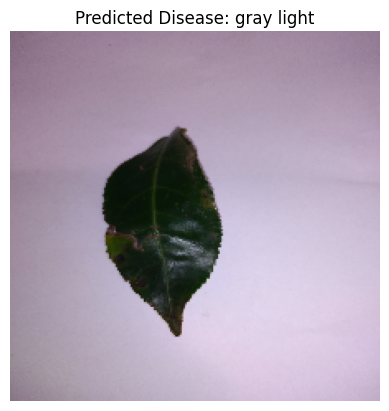

In [30]:
# Test image path
test_image = '/content/dataset/tea leaf dataset/valid/gray light/IMG_20220503_135316.jpg'

# Call the predict_disease_with_loaded_model function
predict_disease(test_image)

1/1 [==============================] - 0s 202ms/step
Predicted Disease: healthy


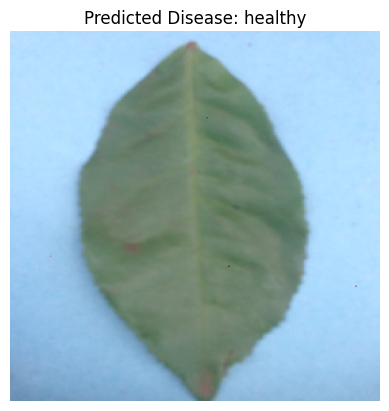

In [29]:
# Test image path
test_image = '/content/dataset/tea leaf dataset/train/healthy/UNADJUSTEDNONRAW_thumb_21c.jpg'

# Call the predict_disease_with_loaded_model function
predict_disease(test_image)

1/1 [==============================] - 0s 260ms/step
Predicted Disease: red leaf spot


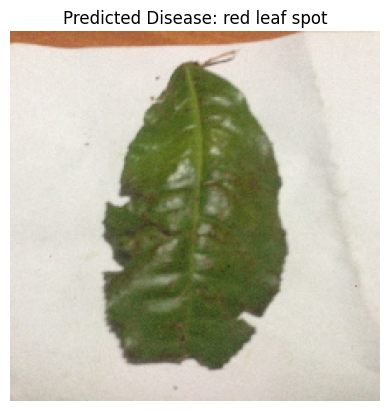

In [31]:
# Test image path
test_image = '/content/dataset/tea leaf dataset/valid/red leaf spot/UNADJUSTEDNONRAW_thumb_1bc.jpg'

# Call the predict_disease_with_loaded_model function
predict_disease(test_image)

1/1 [==============================] - 0s 186ms/step
Predicted Disease: white spot


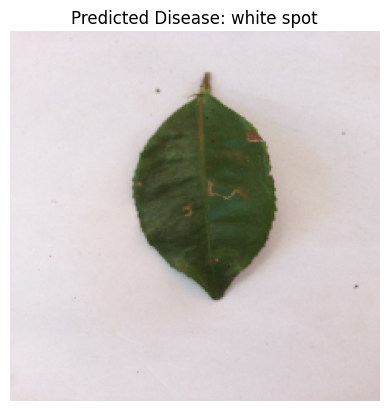

In [32]:
# Test image path
test_image = '/content/dataset/tea leaf dataset/valid/white spot/UNADJUSTEDNONRAW_thumb_9d.jpg'

# Call the predict_disease_with_loaded_model function
predict_disease(test_image)